In [ ]:

!pip3 install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/GAN /clothes_data.zip'

replace Data/01024406_4pl.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm

tensorflow version: 2.13.0


In [ ]:
def plot_array(X,title=""):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

In [ ]:
img_height, img_width, batch_size=64,64,128

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='Data',
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)


Found 3000 files belonging to 1 classes.


In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

In [ ]:
images=train_ds.take(1)

In [ ]:
X=[x for x in images]

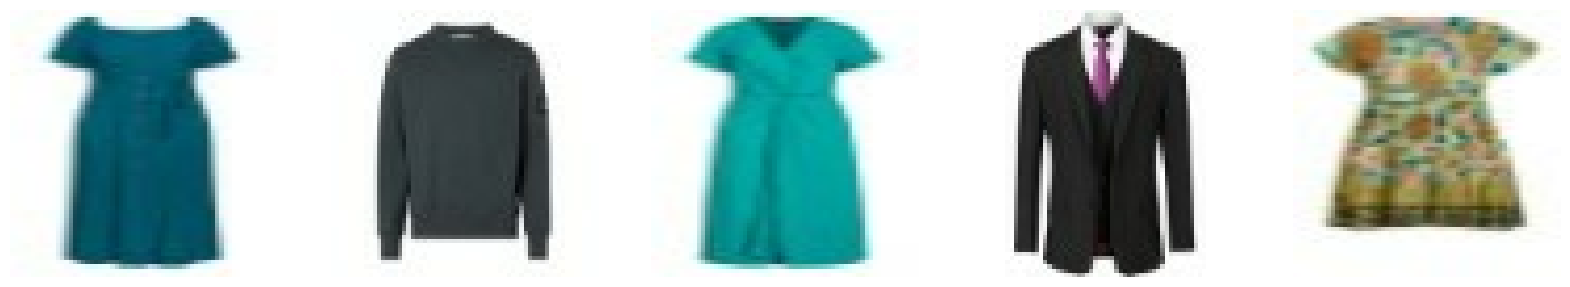

In [ ]:
plot_array(X[0])

#Building a Generator

In [ ]:
def make_generator():

    model=Sequential()

    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))

    # Block 1 dimensionality of the output space  128 * 8
    model.add(Conv2DTranspose(128 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (128 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (128 * 4)
    model.add(Conv2DTranspose(128 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))


    # Block 4: input is 16 x 16 x (128 * 2)
    model.add(Conv2DTranspose(128 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                              activation='tanh', name='conv_transpose_5'))

    return model

In [ ]:
gen = make_generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_transpose_1 (Conv2DTr  (None, 4, 4, 1024)        1638400   
 anspose)                                                        
                                                                 
 bn_1 (BatchNormalization)   (None, 4, 4, 1024)        4096      
                                                                 
 relu_1 (ReLU)               (None, 4, 4, 1024)        0         
                                                                 
 conv_transpose_2 (Conv2DTr  (None, 8, 8, 256)         4194304   
 anspose)                                                        
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                                 
 relu_2 (ReLU)               (None, 8, 8, 256)         0

#Building a Discriminator

In [ ]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

In [ ]:
disc = make_discriminator()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 128)       131072    
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 128)       512       
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)        

#Creating Loss function in generator and discriminator

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [ ]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

#Defining Optimizer in generator and Discriminator

In [ ]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

#Train Step Function

In [ ]:
@tf.function

def train_step(X):

    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)

        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

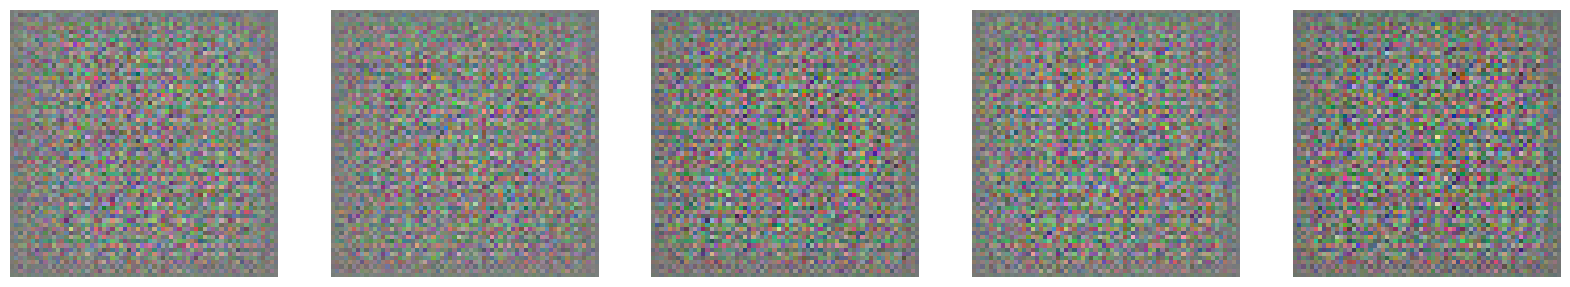

In [ ]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

#Train the model

epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]

epoch 1, iteration 1


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


epoch 1, iteration 2
epoch 1, iteration 3
epoch 1, iteration 4
epoch 1, iteration 5
epoch 1, iteration 6
epoch 1, iteration 7
epoch 1, iteration 8
epoch 1, iteration 9
epoch 1, iteration 10
epoch 1, iteration 11
epoch 1, iteration 12
epoch 1, iteration 13
epoch 1, iteration 14
epoch 1, iteration 15
epoch 1, iteration 16
epoch 1, iteration 17
epoch 1, iteration 18
epoch 1, iteration 19
epoch 1, iteration 20
epoch 1, iteration 21
epoch 1, iteration 22
epoch 1, iteration 23
epoch 1, iteration 24
orignal images


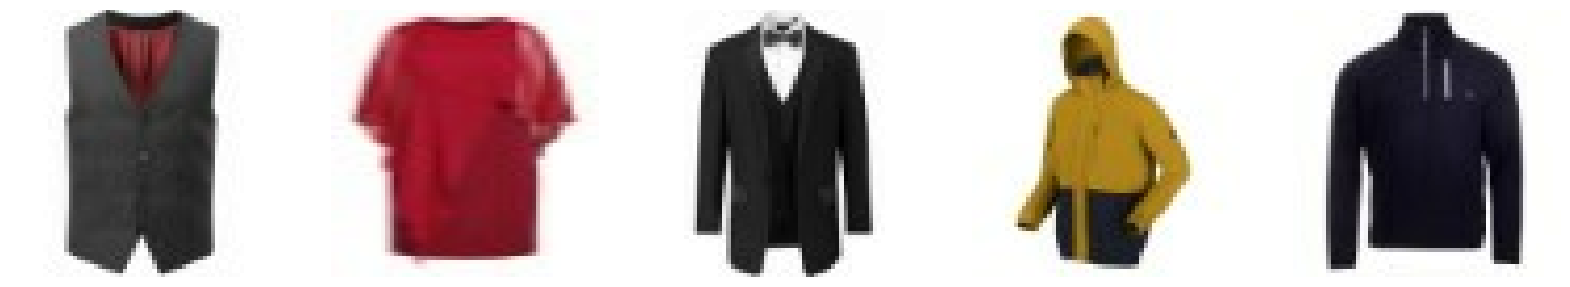

generated images


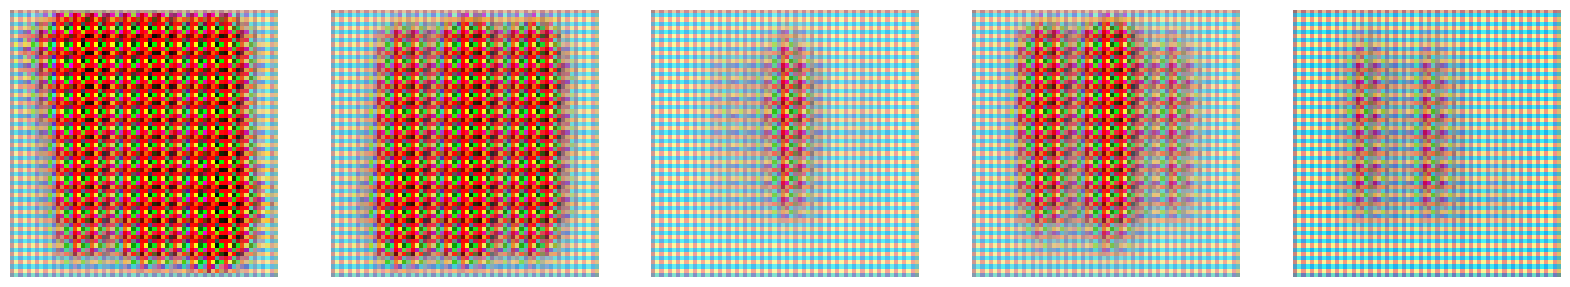

Time for epoch 1 is 326.48089265823364 sec


In [ ]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):

    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):

        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))

        train_step(X)


    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))